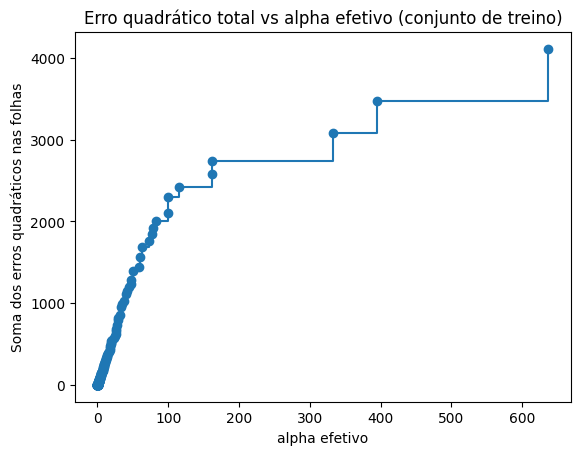

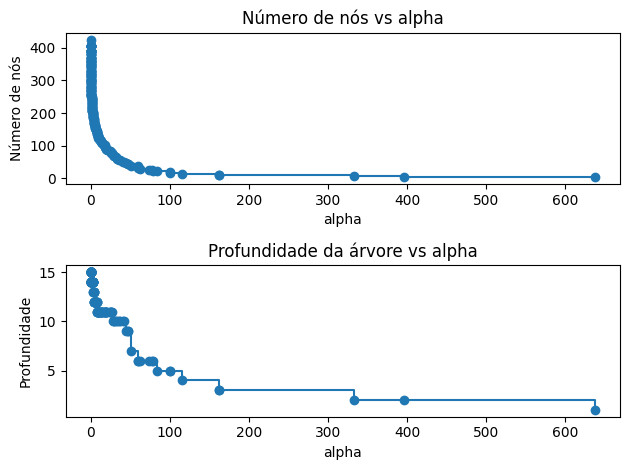

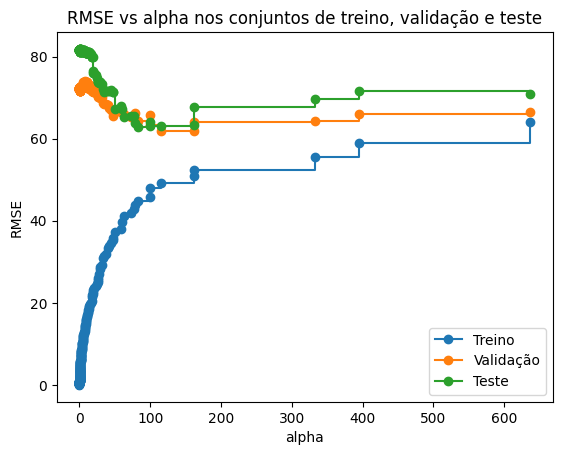

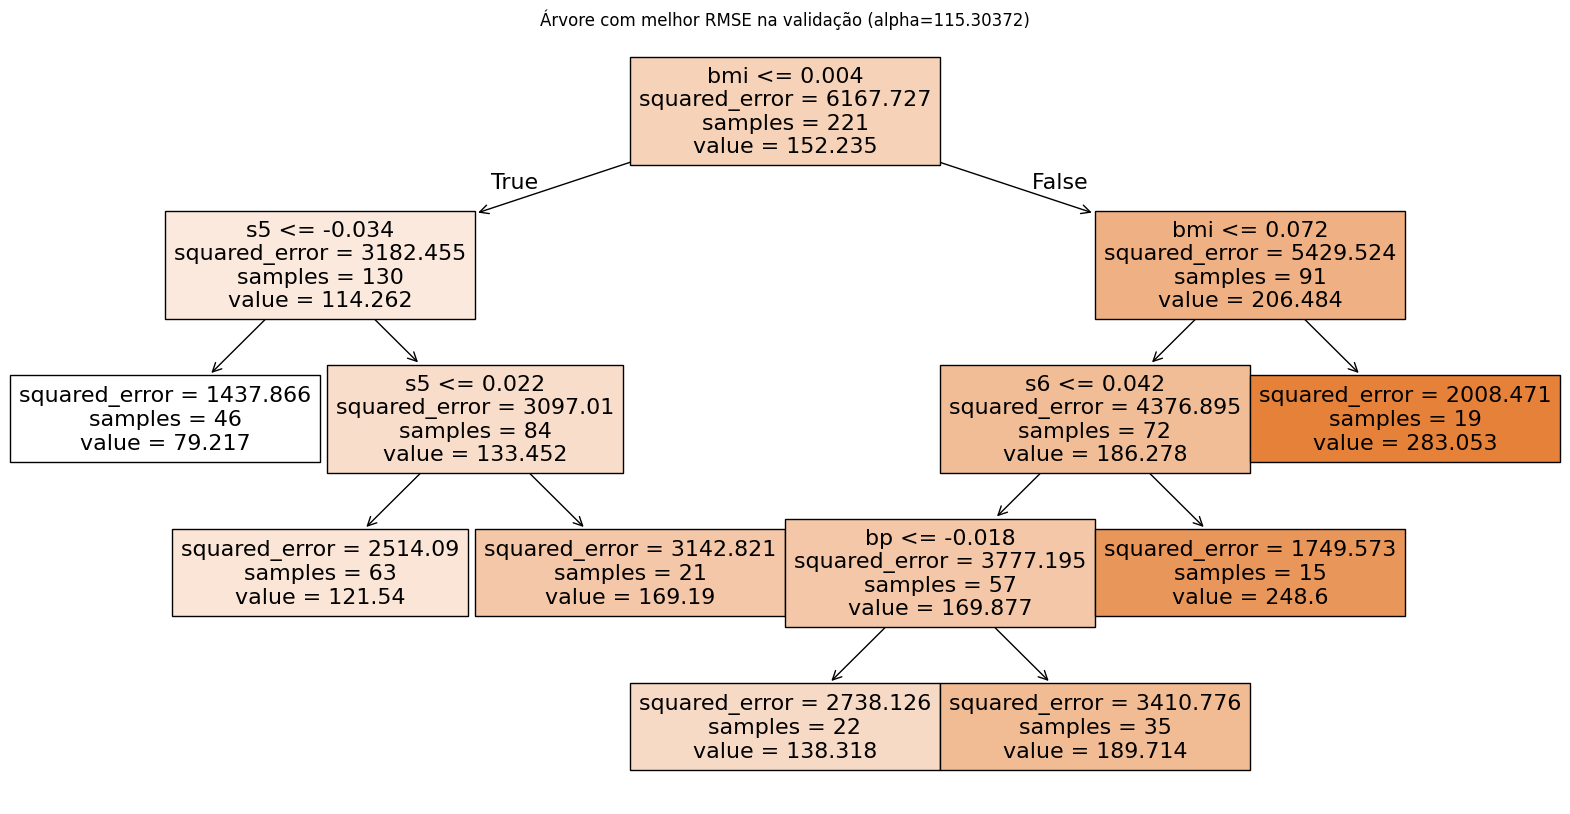

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Carregar dados
X, y = load_diabetes(return_X_y=True)

# Dividir em treino (60%) e teste_val (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
# Dividir teste_val em validação (50%) e teste (50%) => 20% val, 20% teste
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Treinar árvore inicial e obter caminho de poda
clf = DecisionTreeRegressor(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, total_leaf_mse = path.ccp_alphas, path.impurities

# Plotar erro total nas folhas em função de alpha
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], total_leaf_mse[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("alpha efetivo")
ax.set_ylabel("Soma dos erros quadráticos nas folhas")
ax.set_title("Erro quadrático total vs alpha efetivo (conjunto de treino)")

# Treinar modelos com diferentes alphas
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Remover último modelo nulo
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Plotar número de nós e profundidade
node_counts = [clf.tree_.node_count for clf in clfs]
depths = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Número de nós")
ax[0].set_title("Número de nós vs alpha")

ax[1].plot(ccp_alphas, depths, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("Profundidade")
ax[1].set_title("Profundidade da árvore vs alpha")

fig.tight_layout()

# Avaliar desempenho com RMSE nos três conjuntos
train_rmse = [np.sqrt(mean_squared_error(y_train, clf.predict(X_train))) for clf in clfs]
val_rmse = [np.sqrt(mean_squared_error(y_val, clf.predict(X_val))) for clf in clfs]
test_rmse = [np.sqrt(mean_squared_error(y_test, clf.predict(X_test))) for clf in clfs]

# Plotar curva de erro RMSE
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("RMSE")
ax.set_title("RMSE vs alpha nos conjuntos de treino, validação e teste")
ax.plot(ccp_alphas, train_rmse, marker="o", label="Treino", drawstyle="steps-post")
ax.plot(ccp_alphas, val_rmse, marker="o", label="Validação", drawstyle="steps-post")
ax.plot(ccp_alphas, test_rmse, marker="o", label="Teste", drawstyle="steps-post")
ax.legend()
plt.show()

from sklearn.tree import plot_tree

# Encontrar o índice da árvore com menor erro de validação
best_idx = np.argmin(val_rmse)

# Melhor árvore
best_tree = clfs[best_idx]

# Printa a estrutura da melhor árvore
plt.figure(figsize=(20, 10))
plot_tree(best_tree, filled=True, feature_names=load_diabetes().feature_names)
plt.title(f"Árvore com melhor RMSE na validação (alpha={ccp_alphas[best_idx]:.5f})")
plt.show()

